In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Time Series Anomaly Detection with LSTM Autoencoders using Keras and TensorFlow2 in Python
by Venelin Valkov

In [2]:
df = pd.read_csv("data/manipulated_data.csv", delimiter=";", header=3, index_col="Date/Time")  # 
""" df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df.set_index("Date/Time") """
""" df["Manual outlier"] = -1
df["Manual outlier"][26] = 1
df["Manual outlier"][83] = 1
df["Manual outlier"][122] = 1 """


' df["Manual outlier"] = -1\ndf["Manual outlier"][26] = 1\ndf["Manual outlier"][83] = 1\ndf["Manual outlier"][122] = 1 '

In [3]:
df.shape

(17523, 1)

In [4]:
plt.plot(df, label="Water level, Nap (cm)")

Error in callback <function _draw_all_if_interactive at 0x0000019C0CE59D00> (for post_execute):


KeyboardInterrupt: 

In [4]:
train_size = int(len(df) * .95)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(16646, 1) (877, 1)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[["Water level, Nap (cm)"]])

In [6]:
train["Water level, Nap (cm)"] = scaler.transform(train[["Water level, Nap (cm)"]])
test["Water level, Nap (cm)"] = scaler.transform(test[["Water level, Nap (cm)"]])

C:\Users\johanna4303\AppData\Local\Temp\ipykernel_15444\1225289382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Water level, Nap (cm)"] = scaler.transform(train[["Water level, Nap (cm)"]])
C:\Users\johanna4303\AppData\Local\Temp\ipykernel_15444\1225289382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Water level, Nap (cm)"] = scaler.transform(test[["Water level, Nap (cm)"]])


In [7]:
train.head()

,"Water level, Nap (cm)"
Date/Time,
2022-03-08 00:00:04,-0.260092
2022-03-08 00:30:00,-0.260092
2022-03-08 01:00:00,-0.260092
2022-03-08 01:30:00,-0.580031
2022-03-08 02:00:00,-0.580031


In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)


In [10]:
TIME_STEPS = 30

X_train, y_train = create_dataset(
    train[["Water level, Nap (cm)"]], 
    train[["Water level, Nap (cm)"]], 
    TIME_STEPS)

X_test, y_test = create_dataset(
    test[["Water level, Nap (cm)"]], 
    test[["Water level, Nap (cm)"]], 
    TIME_STEPS)

In [11]:
X_train.shape

(16616, 30, 1)

In [12]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(
    units=64, 
    return_sequences=True))

model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2]
)))
# mae = mean absolute error
model.compile(loss="mae", optimizer="adam")

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
468/468 [==============================] - 32s 53ms/step - loss: 0.1621 - val_loss: 0.1071
Epoch 2/10
468/468 [==============================] - 23s 49ms/step - loss: 0.1181 - val_loss: 0.0955
Epoch 3/10
468/468 [==============================] - 25s 53ms/step - loss: 0.1129 - val_loss: 0.1152
Epoch 4/10
468/468 [==============================] - 24s 50ms/step - loss: 0.1090 - val_loss: 0.0905
Epoch 5/10
468/468 [==============================] - 24s 50ms/step - loss: 0.1052 - val_loss: 0.0971
Epoch 6/10
468/468 [==============================] - 24s 51ms/step - loss: 0.1025 - val_loss: 0.0982
Epoch 7/10
468/468 [==============================] - 24s 50ms/step - loss: 0.1038 - val_loss: 0.0914
Epoch 8/10
468/468 [==============================] - 23s 49ms/step - loss: 0.1031 - val_loss: 0.0866
Epoch 9/10
468/468 [==============================] - 23s 50ms/step - loss: 0.1038 - val_loss: 0.0868
Epoch 10/10
468/468 [==============================] - 24s 52ms/step - loss: 0.103

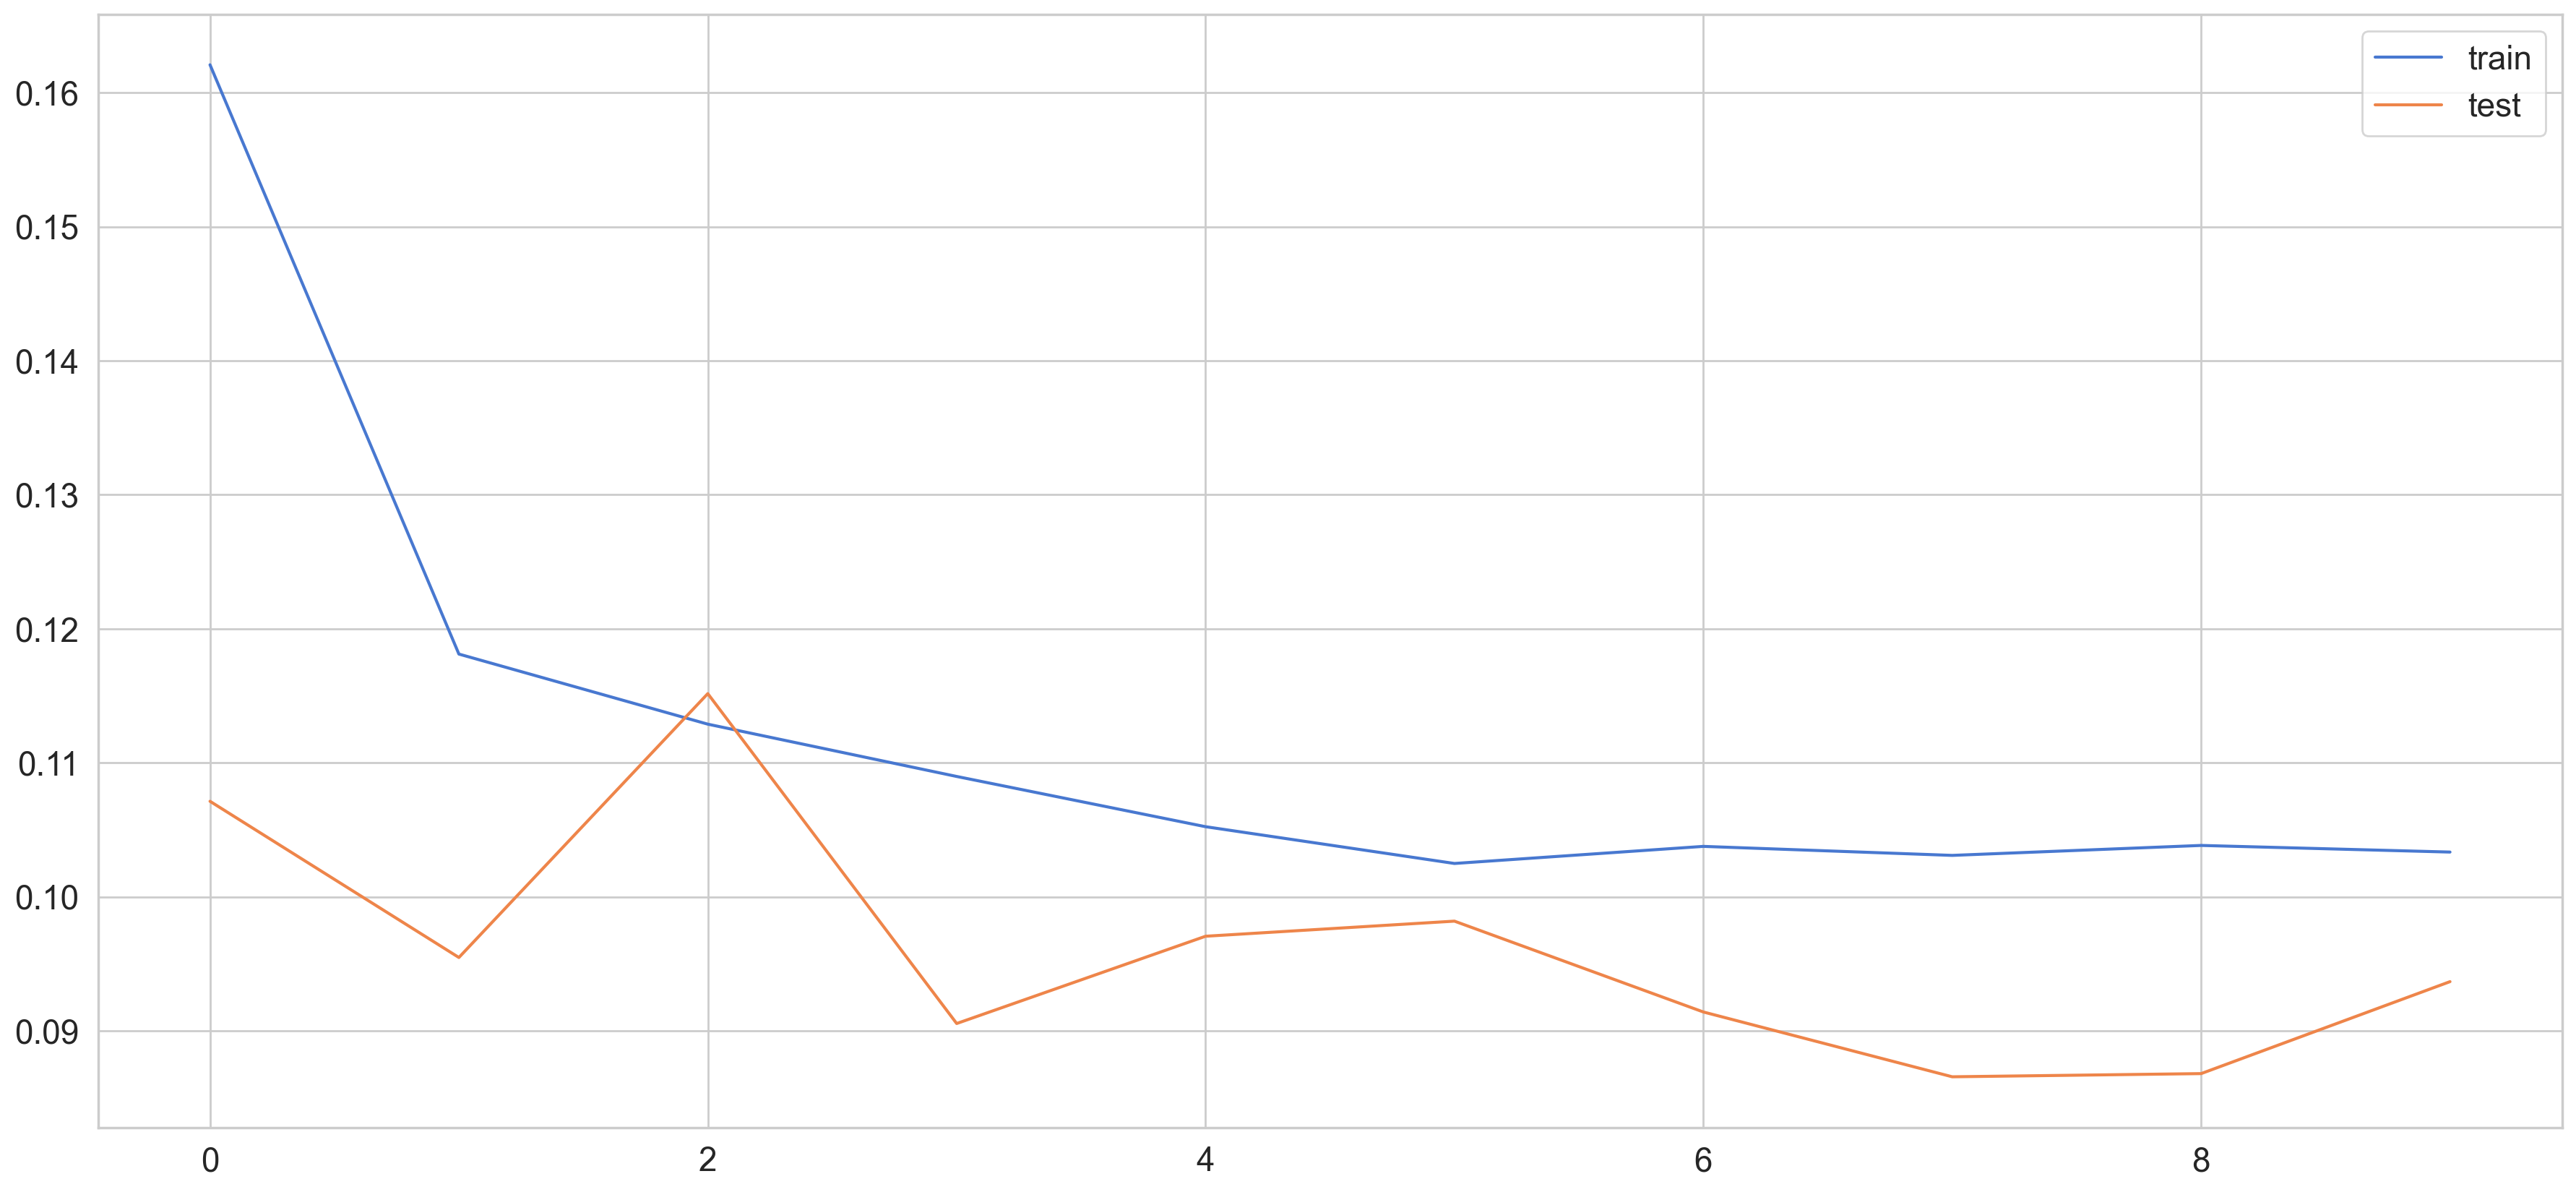

In [14]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()

In [15]:
X_train_pred = model.predict(X_train)

520/520 [==============================] - 12s 20ms/step


In [16]:
train_mae_loss = np.mean(np.abs(X_train_pred, X_train), axis=1)

In [18]:
train_mae_loss.shape

(16616, 1)

C:\Users\johanna4303\AppData\Local\Temp\ipykernel_15444\4276719448.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True)


<Axes: ylabel='Density'>

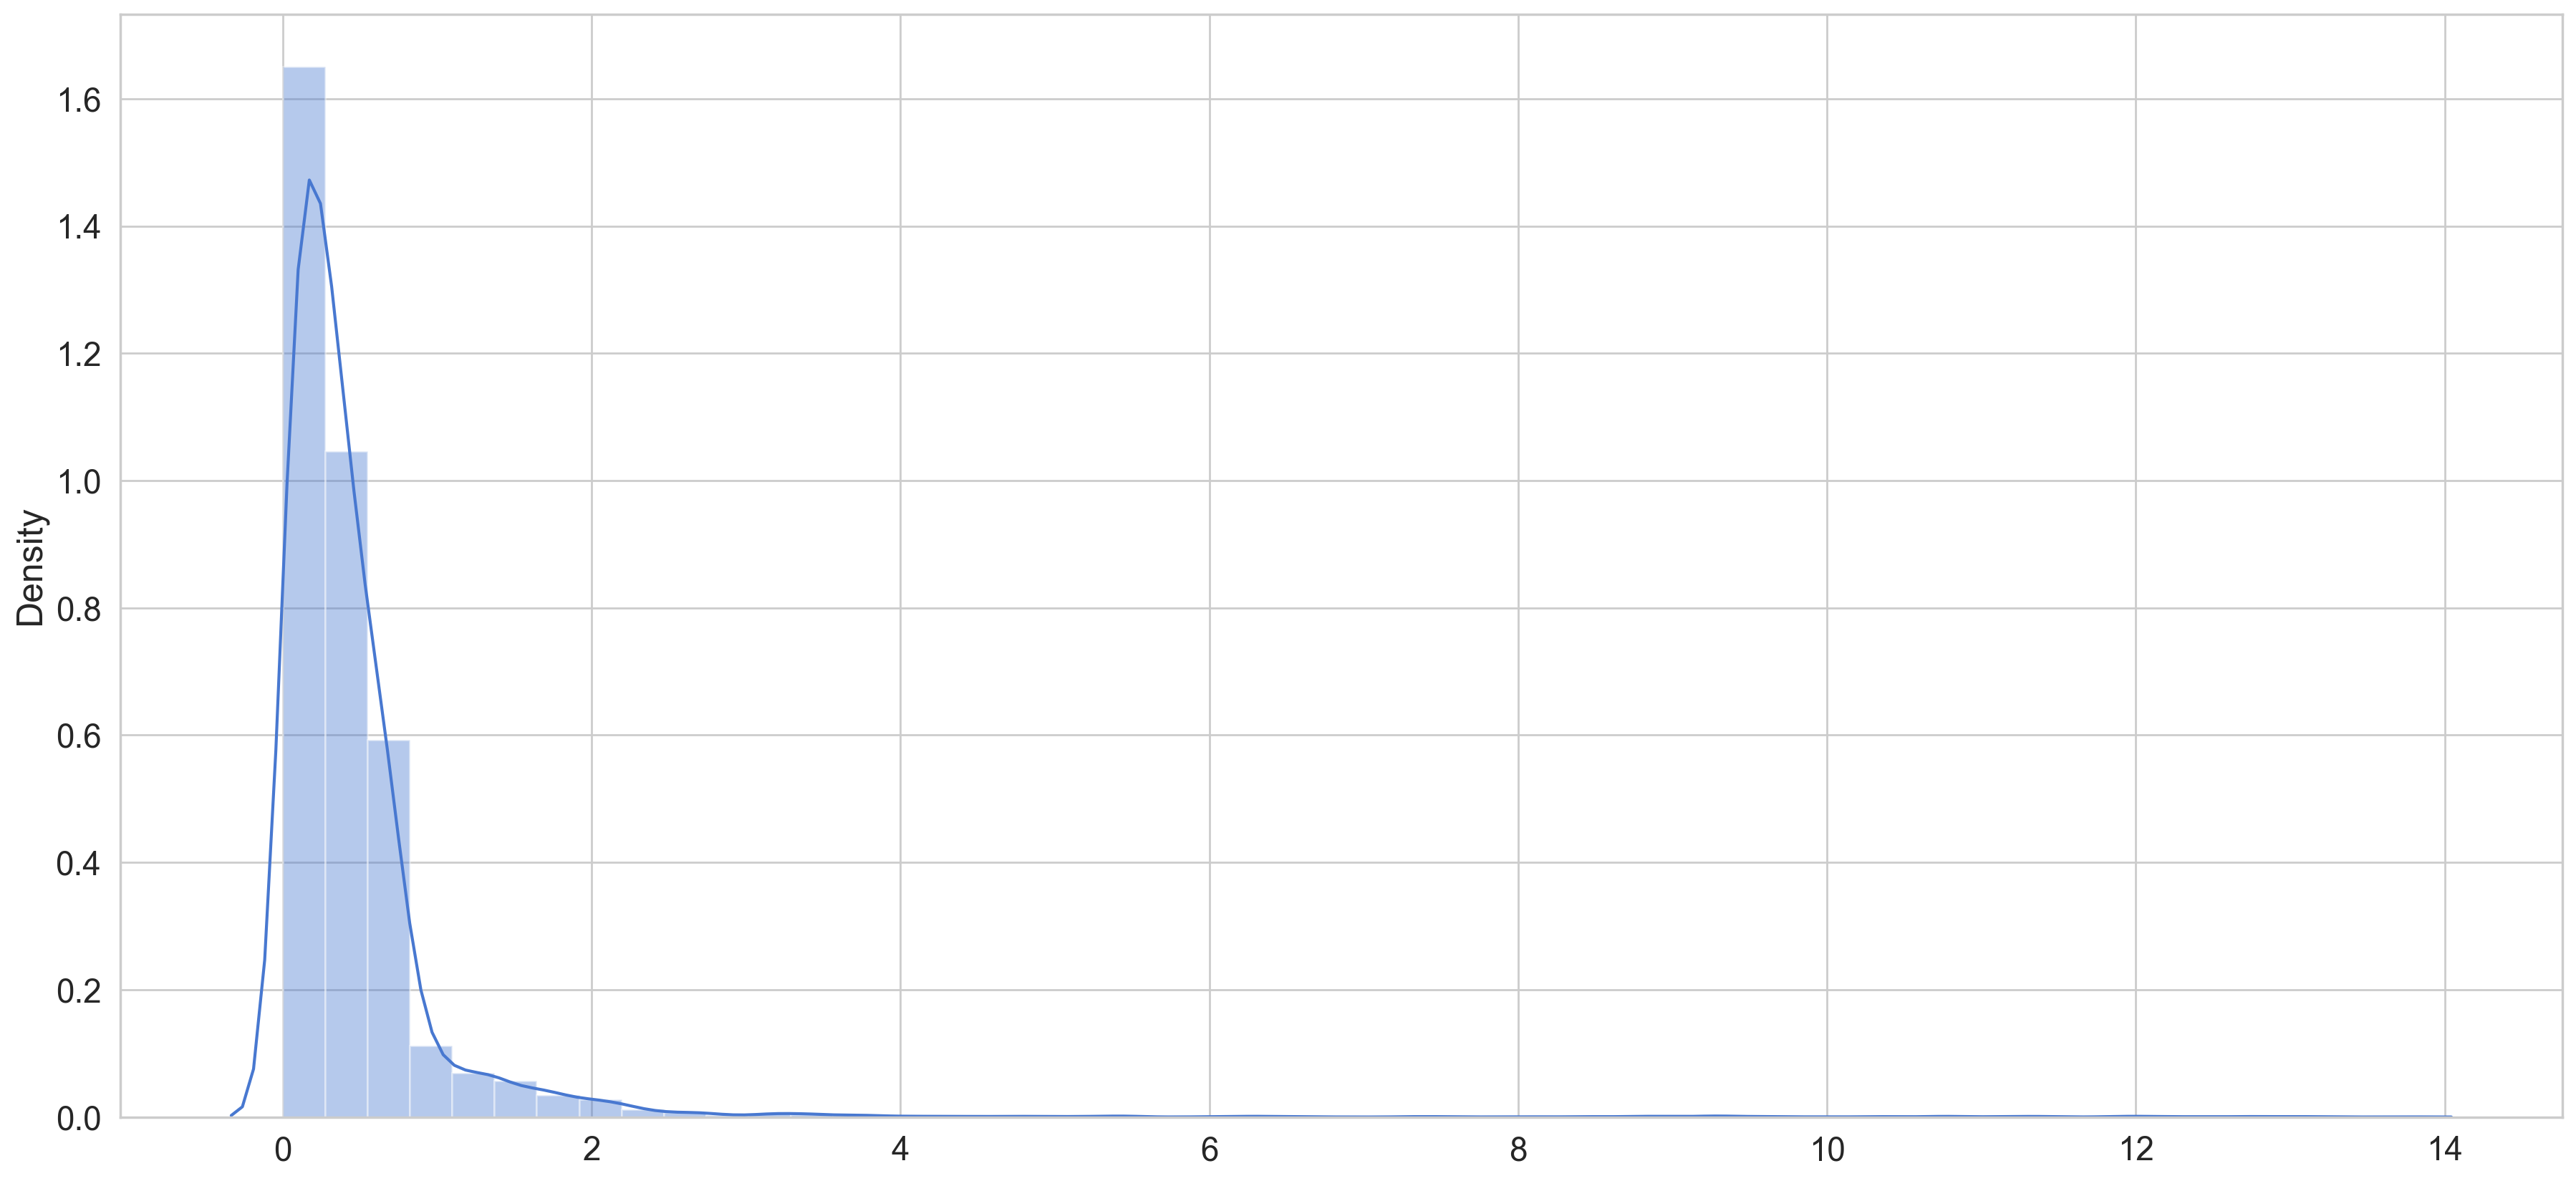

In [19]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [20]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred, X_test), axis=1)

27/27 [==============================] - 1s 21ms/step


In [22]:
THRESHOLD = 1.9

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df["loss"] = test_mae_loss
test_score_df["threshold"] = THRESHOLD
test_score_df["anomaly"] = test_score_df.loss > test_score_df.threshold
test_score_df["water_level"] = test[TIME_STEPS:]["Water level, Nap (cm)"]

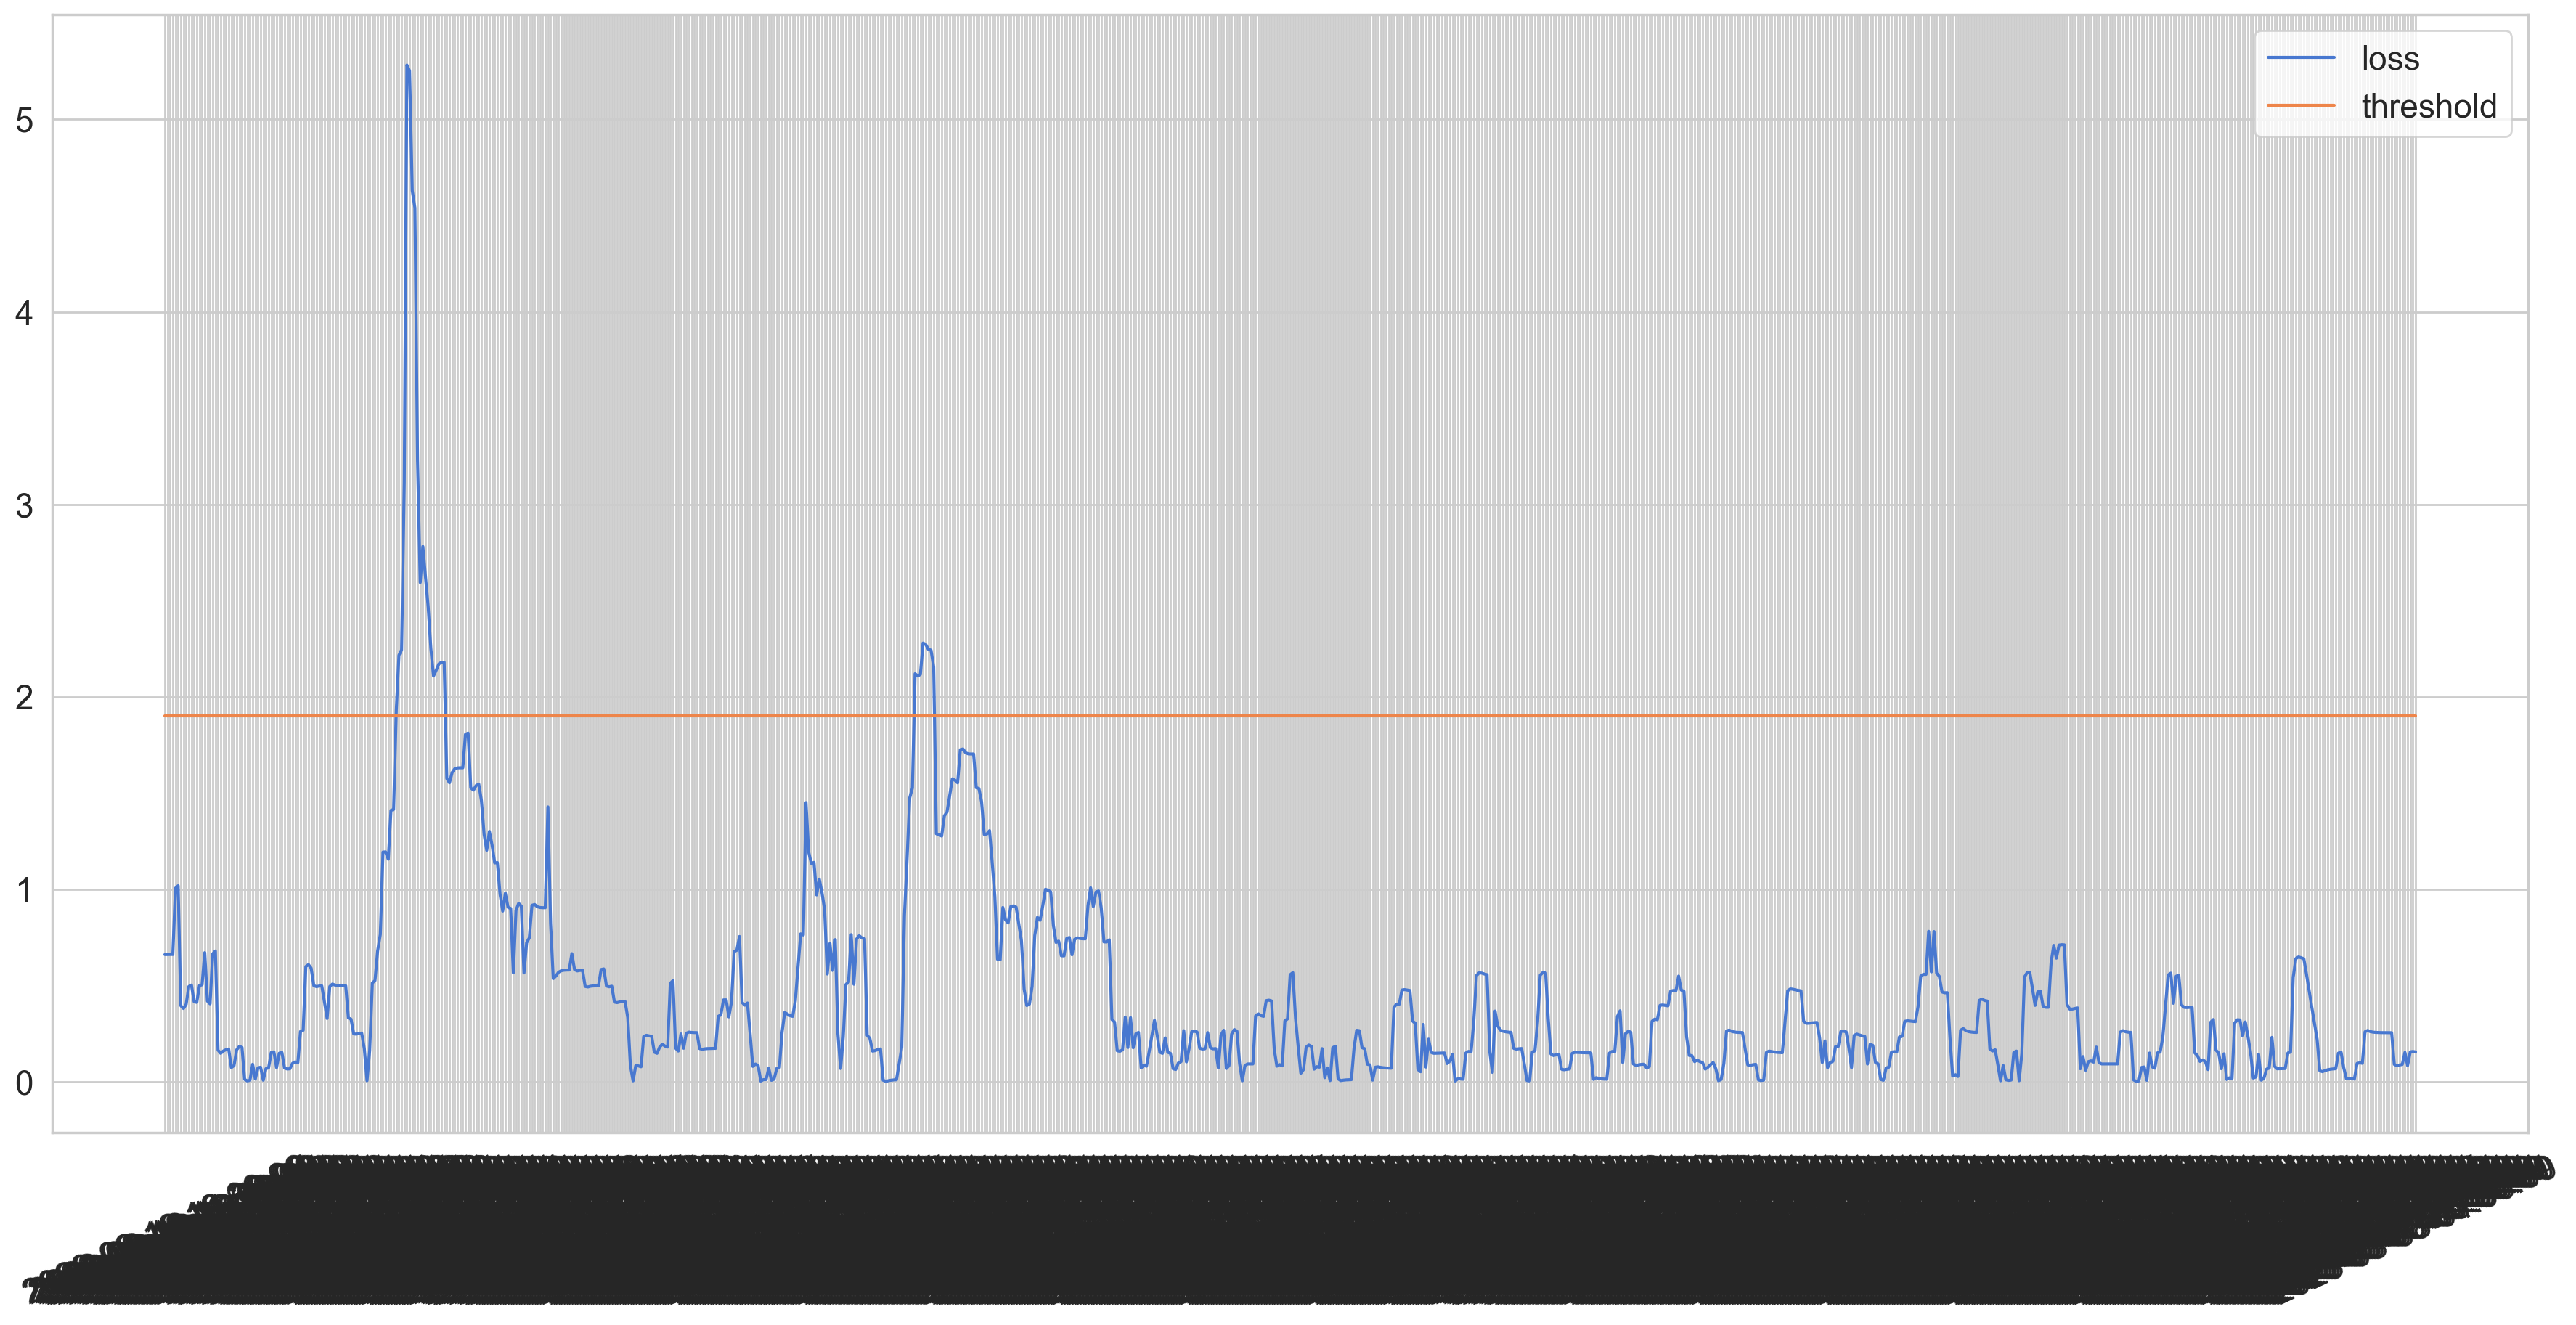

In [23]:
plt.plot(test_score_df.index, test_score_df.loss, label="loss")
plt.plot(test_score_df.index, test_score_df.threshold, label="threshold")
plt.xticks(rotation=25)
plt.legend()

Hopp i videon vid ca 25 minuter, kolla vad han gjorde.

In [24]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,water_level
Date/Time,,,,
2023-02-20 05:30:00,1.928120,1.9,True,2.059464
2023-02-20 06:00:00,2.215633,1.9,True,2.139448
2023-02-20 06:30:00,2.243603,1.9,True,2.939295
2023-02-20 07:00:04,3.114984,1.9,True,4.778943
2023-02-20 07:30:00,5.282484,1.9,True,4.778943
2023-02-20 08:00:00,5.251967,1.9,True,4.778943
2023-02-20 08:30:00,4.630802,1.9,True,4.778943
2023-02-20 09:00:04,4.540333,1.9,True,3.659157
2023-02-20 09:30:00,3.227235,1.9,True,3.019280


In [26]:
test[TIME_STEPS:]["Water level, Nap (cm)"] = test[TIME_STEPS:]["Water level, Nap (cm)"].reshape((-1, 1))

plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:]["Water level, Nap (cm)"]),
    label="Water level, Nap (cm)"
)

sns.scatterplot(
    anomalies.index,
    scaler.inverse_transform(anomalies["Water level, Nap (cm)"]),
    color=sns.color_palette()[3],
    s=52,
    label="anomaly"
)

plt.xticks(rotation=25)
plt.legend

AttributeError: 'Series' object has no attribute 'reshape'